In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import sklearn
from sklearn import metrics
import category_encoders as ce
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
#import data_loader_num_cat
import neural_net 
print(torch.__version__)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

1.8.1


In [2]:
df = pd.read_csv('cars.csv')

# Convert boolean to zero/one as category type
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int).astype(object)
        
# Use price as target and all other columns as features
target = 'price_usd'
features = df.columns[df.columns!=target]        

In [3]:
df.dtypes

manufacturer_name     object
model_name            object
transmission          object
color                 object
odometer_value         int64
year_produced          int64
engine_fuel           object
engine_has_gas        object
engine_type           object
engine_capacity      float64
body_type             object
has_warranty          object
state                 object
drivetrain            object
price_usd            float64
is_exchangeable       object
location_region       object
number_of_photos       int64
up_counter             int64
feature_0             object
feature_1             object
feature_2             object
feature_3             object
feature_4             object
feature_5             object
feature_6             object
feature_7             object
feature_8             object
feature_9             object
duration_listed        int64
dtype: object

In [4]:
# Drop na and define train-test set
df = df.dropna().copy()

target = 'price_usd'
features = df.drop(target, 1).columns

X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target],
                                                    test_size = 0.2, 
                                                    random_state = 2)

In [5]:
#CatBoost encoder used for features
encoder = ce.CatBoostEncoder()

for col in X_train.columns:
    if col in features:
        if X_train[col].dtype == object:
            X_train[col] = encoder.fit_transform(X_train[col], y_train)
            X_test[col] = encoder.transform(X_test[col])

In [6]:
def pd_to_ptrch(x):
    x_torch = torch.tensor(x.values)
    return x_torch

In [7]:
# creating tensor from targets_df 
X_train_torch = pd_to_ptrch(X_train)
y_train_torch = pd_to_ptrch(y_train).to(torch.float32)
y_train_torch = y_train_torch.view(-1,1)

X_test_torch = pd_to_ptrch(X_test)
y_test_torch = pd_to_ptrch(y_test)
y_test_torch = pd_to_ptrch(y_test).to(torch.float32)
y_test_torch = y_test_torch.view(-1,1)

data_train = TensorDataset(X_train_torch, y_train_torch)
data_test = TensorDataset(X_test_torch, y_test_torch)

In [9]:
#Initialize model:
net = neural_net.TheModel

In [11]:
#Define optimizer and loss function
model = net(
              torch.nn.ReLU, 
              #torch.nn.RReLU,
              #torch.nn.ReLU6,
              #torch.nn.LeakyReLU,
               #torch.nn.ELU,
                False,
              [len(X_train.columns), 500, 250, 1])
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) 
#default--> torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), 
#eps=1e-08, weight_decay=0, amsgrad=False)
loss_function = torch.nn.MSELoss()
model

TheModel(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=1, bias=True)
  )
)

In [12]:
#activate devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training = torch.utils.data.DataLoader(data_train, batch_size=64,shuffle=False)

for epoch in range(10):
    for inputs, outputs in training:
        inputs, outputs = inputs.to(device), outputs.to(device)
        optimizer.zero_grad()
        results = model(inputs.float())
        loss = loss_function(results, outputs)
        #loss = loss.float()
        loss.backward()
        optimizer.step()
    print('Loss: {}'.format(loss))  
    
testing = torch.utils.data.DataLoader(data_test, batch_size=X_test.shape[0], shuffle=False)

for inputs, outputs in testing:
    predicted = model(inputs.float()).detach().numpy()
    actual = outputs.numpy()
    print(sklearn.metrics.r2_score(actual, predicted))
    print(sklearn.metrics.mean_absolute_error(actual, predicted))

Loss: 7069170.0
Loss: 9434316.0
Loss: 8773383.0
Loss: 8750412.0
Loss: 8559380.0
Loss: 8197854.5
Loss: 8492614.0
Loss: 8119395.0
Loss: 7137353.0
Loss: 7088066.5
0.7793798089602963
1933.0284


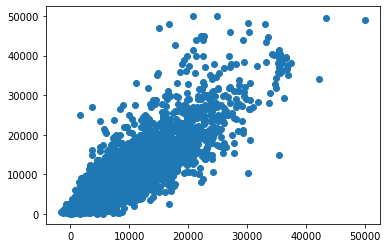

In [13]:
plt.scatter(predicted, actual)